In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m spacy download el # greek lang
!python -m spacy download el_core_news_sm
!pip install greek-stemmer

✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/el_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/el
You can now load the model via spacy.load('el')
✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
from spacy.lang.el.stop_words import STOP_WORDS
import itertools   
from spacy.lang.el import Greek
import string
import el_core_news_sm
import imblearn
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy import stats
from greek_stemmer import GreekStemmer
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
revs_preprocessed = pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/preprocessed_Greek.csv") 
revs_preprocessed.sample(5)
revs_preprocessed = revs_preprocessed.dropna()
revs_preprocessed['review'] = revs_preprocessed['review'].astype(str)

In [ ]:
revs_preprocessed.approved.value_counts()

1    120360
0      7052
Name: approved, dtype: int64

If we use stemming

In [ ]:
stemmer = GreekStemmer()

def stemming(text):
    text = [stemmer.stem(word.upper()) for word in text.split()]

    return " ".join(text)

#revs_preprocessed["review"] = revs_preprocessed["review"].map(stemming)
#revs_preprocessed["review"] = revs_preprocessed.review.str.lower()

In [ ]:
revs_preprocessed = revs_preprocessed.sample(frac=1)
revs_preprocessed

,review,approved
42134,γιατρος εξαιρετικη επισκεπτομαι 2 τελευταια χρ...,1
113734,πολυ καλος γιατρος,1
90690,πολυ καλη ιατρος προχωραμε εξειδικευμενες εξετ...,1
58679,ήταν πολυ καλος δουλεια,1
110779,ακριβης κ αναλυτικος,1
...,...,...
21439,πρωτη φορα κλεινω ραντεβου γιατρο καλουν ωρα κ...,1
56752,πολυ καλοςμε εμπειρια γιατρος πανω ολα ανθρωπος,1
54776,γιατρος καταρτισμενος προσιτος διερευνησε βαθο...,1
92435,εξαιρετικος φιλικος 3 παιδια,1


## Split Dataset

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# splitting in train-validation-test sets in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# sss: stratified shuffle split

# We will use this object to split the raw dataset in Train - Test in a stratified manner.

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)

test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [ ]:
# We will use this object to split the Train dataset in Train and Validation in a stratified manner.

val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [ ]:
reviews = revs_preprocessed.review
approval = revs_preprocessed.approved

In [ ]:
# splitting in train-val and test

X_train_val, X_test, y_train_val, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in test_sss.split(reviews, approval):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = reviews.iloc[train_index], reviews.iloc[test_index]
    y_train_val, y_test = approval.iloc[train_index], approval.iloc[test_index]

TRAIN-VAL: [ 82457  40187  40043  91693  31573 126703  71766 125852  43561  91622] TEST: [ 48330  94657 114260  40239 101536  36864  29050   7122  21263  44303]
TRAIN-VAL: [73156 58021 59365 27179 94762 10497 67233 17182 84367 20075] TEST: [ 32753  97751  13927  30167  69184  88427  17787  68858  83126 116464]
TRAIN-VAL: [125388  86025  78588 110340  76677  81367 116099  39808  37400      6] TEST: [118357   7754 118674  36094  46872  25823  20654  55405  63803  69622]
TRAIN-VAL: [ 49035 121049  69999 107751  84425 104095 125518 112449  51904  53617] TEST: [68027 60794 11767 11719 31950 47271 81582 28971 15824 58403]
TRAIN-VAL: [ 16681  52520  91314   8940  82564  51519  35232 109670  31265  78684] TEST: [ 4768 20555 66274 64194 49224  1419  4606 70038 73158  5842]


In [ ]:
X_train_val.head()

36437     γνωριζει αριστα δουλεια δινει εξαιρετικη προσο...
79257     ραντεβου εγινε ωρα τουπολυ καλος επιστημονας ε...
68099                                            πολυ καλος
30212                                    δεν υπαρχουν λογια
114797    κλινικη εξεταση ληψη ιστορικου παρακλινικες εξ...
Name: review, dtype: object

In [ ]:
X_train_val.shape, X_train_val.dropna().shape

((108300,), (108300,))

In [ ]:
y_train_val.shape, y_train_val.dropna().shape

((108300,), (108300,))

In [ ]:
# We reset the indexes for bot the X-train-val and y-train-val in order to break them 
# again into two subsets.
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

In [ ]:
# splitting the train-val dataset into train and validation dataset

X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

TRAIN: [ 81938  30988  34406  10973    636  59632  66476  95354  92178 102431] VALID: [ 4768 20555 66274 64194 49224  1419  4606 70038 73158  5842]
TRAIN: [ 30014 103652 107119  27713  19994   4881  44402  66722  24989  57429] VALID: [ 4768 20555 66274 64194 49224  1419  4606 70038 73158  5842]
TRAIN: [ 52654  36708  80607   8442 108034 107195  25843  18606  61439  61519] VALID: [ 4768 20555 66274 64194 49224  1419  4606 70038 73158  5842]
TRAIN: [19772 47443 70624 27828 95105 74593 97998 32485 34874 47525] VALID: [ 4768 20555 66274 64194 49224  1419  4606 70038 73158  5842]
TRAIN: [13985 25928 41869 53268 15336 63983 39082 57268 32744 22757] VALID: [ 4768 20555 66274 64194 49224  1419  4606 70038 73158  5842]


In [ ]:
print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train_val shape: (108300,)
y_train_val shape: (108300,)

X_train shape: (86640,)
y_train shape: (86640,)

X_val shape: (21660,)
y_val shape: (21660,)

X_test shape: (19112,)
y_test shape: (19112,)


### Labels One-hot Encoding 

In [ ]:
# Encoding the labels using a One-Hot Encoder
y_enc = OneHotEncoder(sparse=False)

In [ ]:
#y_enc.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# At first we run fit_transform on the Training data
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
y_train_final =  np.asarray(y_train)
y_train_final

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
y_val_final = np.asarray(y_val)
y_test_final = np.asarray(y_test)

In [ ]:
# Then we use the fitted One-hot-Encoder to transform the rest of the data
y_val_enc = y_enc.transform(y_val.values.reshape(-1, 1))

y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [ ]:
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_val shape: {}'.format(y_val_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (86640, 2)
y_val shape: (21660, 2)
y_test shape: (19112, 2)


In [ ]:
temp.sum(axis=0).head(10)

0     4795.0
1    81845.0
dtype: float64

In [ ]:
temp.sum(axis=1).sample(10)

79408    1.0
58688    1.0
65669    1.0
56234    1.0
4590     1.0
69162    1.0
22989    1.0
69387    1.0
42652    1.0
35132    1.0
dtype: float64

In [ ]:
# deleting the variable (just for demonstration purposes)
del temp

do we need the target variable one-hot encoded?

## Tokenization

In [ ]:
# Load Greek tokenizer, tagger, parser, NER and word vectors
parser = Greek()

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

## Handling Text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# A pandas Series is also an iterable. So we can handle it like a List.
# Concatenating all reviews into one text.
corpora = " ".join(reviews)

print(corpora[:1000])

γιατρος εξαιρετικη επισκεπτομαι 2 τελευταια χρονια προτεινω ανεπιφυλακτα ολους πολυ καλος γιατρος πολυ καλη ιατρος προχωραμε εξειδικευμενες εξετασεις ήταν πολυ καλος δουλεια ακριβης κ αναλυτικος σημαντικο εμπνεει εμπιστοσυνη επισης επεξηγηματικη σχετικα ολη διαδικασια έμεινα πολυ ευχαριστημενη καταρτισμενοςεπαγγελματιας φιλικος κατανοηση αψογο ιατρειο εξοπλισμος πολυ καλη δουλεια έδειξε ενδιαφερον βοηθησε πολυ πολυ προσιτος φιλικος χωρις υστερει επαγγελματισμο προθυμος λυσει ολες αποριες συνιστουσα ανεπιφυλακτα γιατρος εμπνεει εμπιστοσυνη πρωτη στιγμη ασχολειται βαθος καθε περιπτωση καταρτισμενη καθησυχαστικη πολυ ευγενικη ακριβως αυτο καθενας ηθελε γιατρος ενδιαφερον προβλημα ψαξιμο εκ βαθεως βγει σωστο πορισμα προβλημα αντιμετωπιζεις πολυ καλη γιατρος γνωστης αντικειμενου αλλα ανθρωπος ολα πηγαν πολυ καλα ιδιαιτερα ενημερωτικη αναλυτικη συγχαρητηρια γιατρο συμμετοχη οργανωση τετοιων ενεργειων παρα πολυ καλος γιατρος βοηθησε προβλημα φιλικος ανθρωπος συστηνω ανεπιφυλαχτα πρωτη επισκεψ

In [ ]:
top_words = Counter(corpora.split()).most_common()
top_words[:20]

[('πολυ', 59352),
 ('γιατρος', 31458),
 ('ανεπιφυλακτα', 15773),
 ('καλος', 14319),
 ('δεν', 13315),
 ('εμπιστοσυνη', 12472),
 ('εξαιρετικος', 11748),
 ('προβλημα', 10447),
 ('ραντεβου', 10392),
 ('καλη', 9445),
 ('ανθρωπος', 8797),
 ('ολα', 8356),
 ('συστηνω', 8107),
 ('περιπτωση', 7216),
 ('εξαιρετικη', 7194),
 ('κ', 6784),
 ('ευγενικος', 6478),
 ('επαγγελματιας', 6386),
 ('προσιτος', 6261),
 ('γιατρο', 6098)]

In [ ]:
# Total Number of Words to use for vectorization. 
# The vectorizer will keep the K most common tokens (words-characters)
max_words = 3000

stop_words = [
    'αν', 'απ', 'απο', 'ας', 'για', 'γιατι', 'εγω', 'ειναι', 'ενα',
    'εσυ', 'ετσι', 'εχει', 'η', 'ηταν', 'θα', 'και', 'και', 'κι', 'κ', 'μα', 'μας',
    'με', 'μες', 'μη', 'μην', 'μια', 'μου', 'μου', 'μου,', 'μ’', 'ν', 'να', 'ο',
    'οι', 'ομως', 'οπως', 'οταν', 'οτι', 'πια', 'πιο', 'που', 'πως', 'πως', 'σ',
    'σαν', 'σε', 'σου', 'σου', 'σου', 'στα', 'στη', 'στην', 'στις', 'στο', 'στον',
    'τ', 'τα', 'τη', 'την', 'της', 'τι', 'τις', 'το', 'τον', 'του', 'τους', 'των'
]

punctuations = string.punctuation

### Bag of Words Approach (BoW)


In [ ]:
# This vectorizer will give the number of appearances of each word
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words=stop_words,
    tokenizer=spacy_tokenizer,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=True, # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['αν', 'απ', 'απο', 'ας', 'για', 'γιατι', 'εγω',
                            'ειναι', 'ενα', 'εσυ', 'ετσι', 'εχει', 'η', 'ηταν',
                            'θα', 'και', 'και', 'κι', 'κ', 'μα', 'μας', 'με',
                            'μες', 'μη', 'μην', 'μια', 'μου', 'μου', 'μου,',
                            'μ’', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9057984bf8>,
                vocabulary=None)

Fitting the CountVectorizer **ONLY ON THE TRAINING DATASET**

In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow = counter_vectorizer.fit_transform(X_train)

In [ ]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow = counter_vectorizer.transform(X_val)
X_test_enc_bow = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow.shape))

X_train encoded shape: (86640, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
X_train_enc_bow[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

### Tf-idf vectorizer Approach

In [ ]:
# This vectorizer will give the number of appearances of each word
tfidf_vectorizer = TfidfVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words=stop_words,
    tokenizer=spacy_tokenizer,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    #binary=False, # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['αν', 'απ', 'απο', 'ας', 'για', 'γιατι', 'εγω',
                            'ειναι', 'ενα', 'εσυ', 'ετσι', 'εχει', 'η', 'ηταν',
                            'θα', 'και', 'και', 'κι', 'κ', 'μα', 'μας', 'με',
                            'μες', 'μη', 'μην', 'μια', 'μου', 'μου', 'μου,',
                            'μ’', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9057984bf8>,
                vocabulary=None)

In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc = tfidf_vectorizer.transform(X_val)
X_test_enc = tfidf_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc.shape))
print('X_val encoded shape: {}'.format(X_val_enc.shape))
print('X_test encoded shape: {}'.format(X_test_enc.shape))

X_train encoded shape: (86640, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
X_train_enc[0].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

Vectorized Representation

In [ ]:
X_counts = X_train_enc_bow
X_tfidf = X_train_enc
y = y_train

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    if plot:
        plt.scatter(
            lsa_scores[:, 0],
            lsa_scores[:, 1],
            s=8,
            alpha=0.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors),
        )
        red_patch = mpatches.Patch(color="orange", label="Not Approved")
        green_patch = mpatches.Patch(color="blue", label="Approved")
        plt.legend(handles=[red_patch, green_patch], prop={"size": 16})


### Comparison

Visualization of vectorized text represantation in order to choose the best one

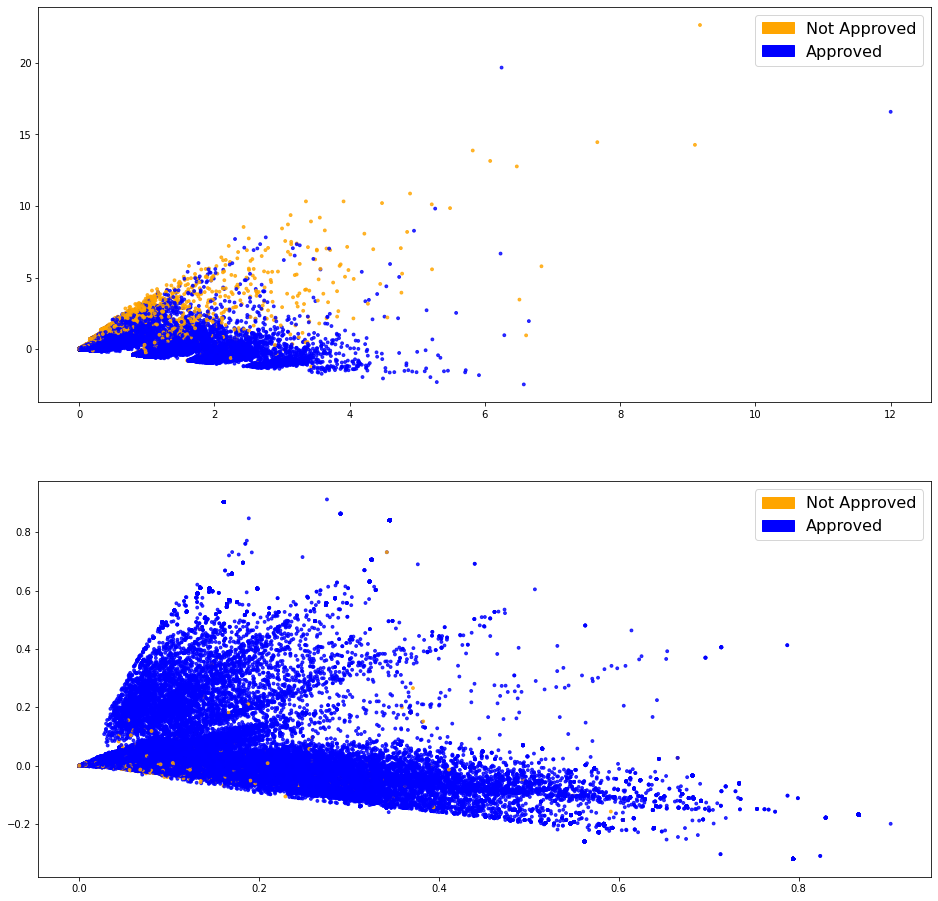

In [ ]:
plt.figure(1, figsize=(16, 16))
plt.subplot(2, 1, 1)
plot_LSA(X_counts, y)
plt.subplot(2, 1, 2)
plot_LSA(X_tfidf, y)

# Modeling

## Feed-Forward model

### With Imbalanced dataset

In [ ]:
# !pip install pydot
# !pip install graphviz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

In [ ]:
# Some parameters that we will use:

# Number of Classes for the Y labels
nb_classes = len(y_train.value_counts())

print('Number of Classes: {}'.format(nb_classes))

# Number of Epochs that we will train our Feed Forward Network
nb_epoch = 10

# The batch_size of the data that  will be fed to the Model when training
batch_size = 32 

# Dropout Rate of the Dropout Layer (how many neurons to shutdown each time)
dropout_rate = 0.4

Number of Classes: 2


Model Setup

In [ ]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model = Sequential()

# add a dense layer (MLP)
model.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model.add(Dense(512))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model.add(Dense(nb_classes)) # if we want to change the one-hot, set dense 1

# use a softmax activation on 2nd MLP's outputs
model.add(Activation('sigmoid'))

# we have defined the structure of the model

# print model layers' info
print(model.summary())

Building model...

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               1536512   
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None,

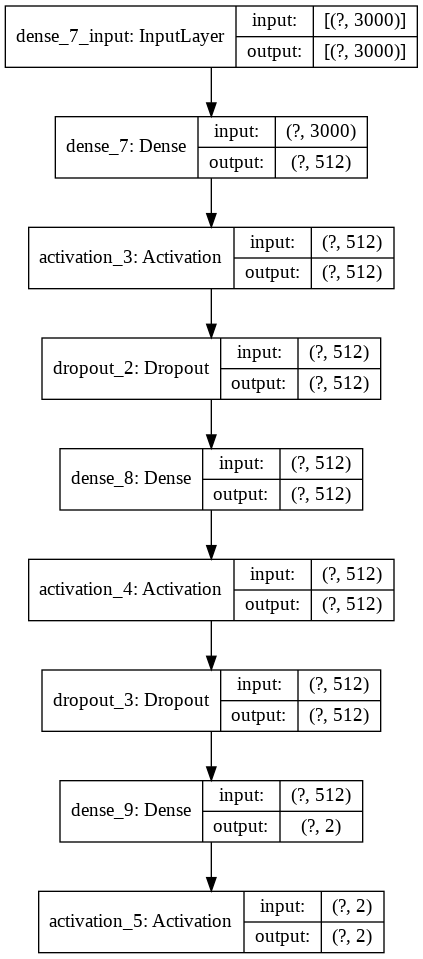

In [ ]:
plot_model(model,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'],
)
# we have compiled a model and it is ready to be trained

In [ ]:
X_train_enc_bow

<86640x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 693843 stored elements in Compressed Sparse Row format>

In [ ]:
y_train_enc.shape

(86640, 2)

In [ ]:
X_val_enc_bow

<21660x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 173663 stored elements in Compressed Sparse Row format>

In [ ]:
y_val_enc.shape

(21660, 2)

#### Fitting (training) our Feed Forward Network Model

In [ ]:
# We train (fit our data to) our model
history = model.fit(
    x=X_train_enc_bow.todense(),           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_val_enc_bow.todense(),               # the validation split that we did before
    y_val_enc)
)

Epoch 1/10
2708/2708 - 8s - loss: 0.0218 - categorical_accuracy: 0.9917 - val_loss: 0.2201 - val_categorical_accuracy: 0.9660
Epoch 2/10
2708/2708 - 8s - loss: 0.0224 - categorical_accuracy: 0.9916 - val_loss: 0.2210 - val_categorical_accuracy: 0.9661
Epoch 3/10
2708/2708 - 8s - loss: 0.0221 - categorical_accuracy: 0.9916 - val_loss: 0.2313 - val_categorical_accuracy: 0.9664
Epoch 4/10
2708/2708 - 9s - loss: 0.0206 - categorical_accuracy: 0.9917 - val_loss: 0.2412 - val_categorical_accuracy: 0.9667
Epoch 5/10
2708/2708 - 8s - loss: 0.0211 - categorical_accuracy: 0.9922 - val_loss: 0.2463 - val_categorical_accuracy: 0.9664
Epoch 6/10
2708/2708 - 8s - loss: 0.0207 - categorical_accuracy: 0.9918 - val_loss: 0.2661 - val_categorical_accuracy: 0.9655
Epoch 7/10
2708/2708 - 8s - loss: 0.0220 - categorical_accuracy: 0.9919 - val_loss: 0.2955 - val_categorical_accuracy: 0.9652
Epoch 8/10
2708/2708 - 8s - loss: 0.0217 - categorical_accuracy: 0.9919 - val_loss: 0.2819 - val_categorical_accuracy:

In [ ]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

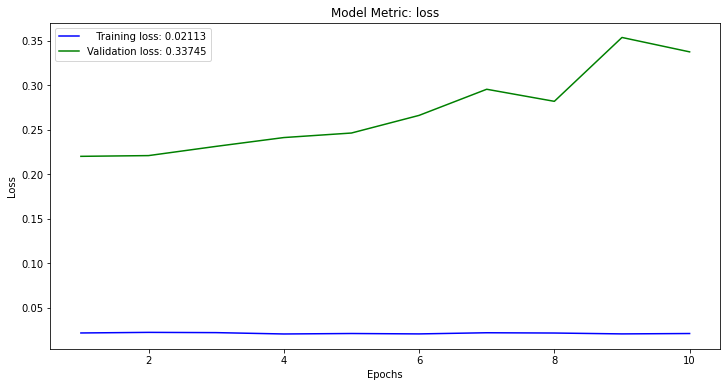

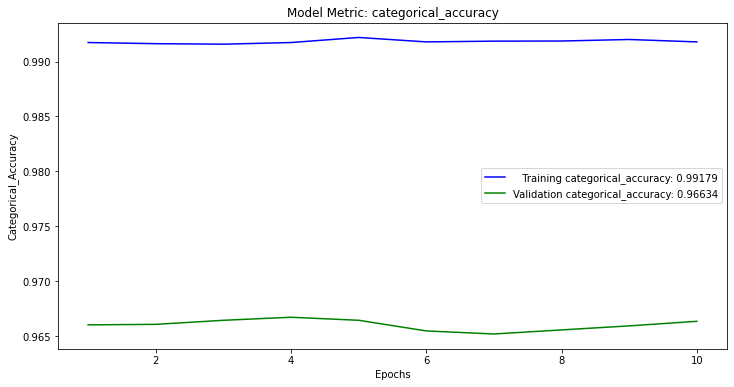

In [ ]:
plot_keras_history(history)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model.evaluate(
    X_test_enc_bow.todense(),    # features
    y_test_enc,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

598/598 - 1s - loss: 0.3584 - categorical_accuracy: 0.9669


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.3583679795265198

Test accuracy: 96.688 %


#### Model Prediction 

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict(X_test_enc_bow)
y_test_pred_probs

array([[8.3999044e-21, 1.0000000e+00],
       [1.1566464e-19, 1.0000000e+00],
       [2.7163253e-06, 9.9999666e-01],
       ...,
       [1.0000000e+00, 5.5191091e-10],
       [1.8295895e-15, 1.0000000e+00],
       [4.2953096e-05, 9.9996233e-01]], dtype=float32)

In [ ]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

# y_test_preds = model.predict_classes(X_test_enc)

y_test_preds = np.argmax(model.predict(X_test_enc_bow), axis=-1)

y_test_preds[:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

In [ ]:
y_test_pred = get_one_hot_predictions(y_test_pred_probs)
y_test_pred

# check that each line has only one 1. 
# y_test_pred.sum(axis=1)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [ ]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_approval = y_enc.inverse_transform(y_test_pred).flatten()
y_test_pred_approval[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
# More Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_pred_approval)
conf_mat

array([[  698,   360],
       [  273, 17781]])

In [ ]:
# a bit prettier
pd.DataFrame(conf_mat,
             columns = y_enc.categories_,
             index=y_enc.categories_)

,0,1
0,698,360
1,273,17781


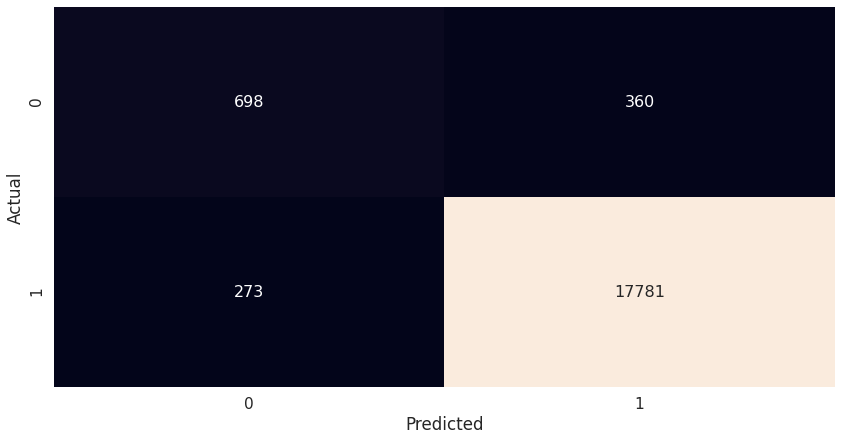

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred_approval))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1058
           1       0.98      0.98      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.85      0.82      0.84     19112
weighted avg       0.97      0.97      0.97     19112



In [ ]:
# Predicting a single review

input_rev = """
ο γιατρος ηταν απαραδεκτος
"""

# vectorizing Song with Count Vectorizer
rev_vect = counter_vectorizer.transform([input_rev])

print(rev_vect.shape, end='\n\n')

rev_pred = model.predict(rev_vect)

print('Probabilities', end='\n\n')
print(rev_pred, end='\n\n')

rev_pred_hot = get_one_hot_predictions(rev_pred)

print('Probabilities One Hot Vector', end='\n\n')
print(rev_pred_hot, end='\n\n')

print('Approval Prediction:', end='\n\n')
print(y_enc.inverse_transform(rev_pred_hot)[0][0])

(1, 3000)

Probabilities

[[9.9997759e-01 2.3054521e-05]]

Probabilities One Hot Vector

[[1. 0.]]

Approval Prediction:

0


### Oversampling

#### Fitting (training) our Feed Forward Network Model

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

num_words = len(counter)

max_length = 100 # mean is 800
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
not_appr_upsampled = resample(not_approved,
                          replace=True, # sample with replacement
                          n_samples=len(approved)//4, # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([approved, not_appr_upsampled])

# check new class counts
print(upsampled.approved.value_counts())
upsampled = upsampled.sample(frac=1)

1    81845
0    20461
Name: approved, dtype: int64


In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow = counter_vectorizer.fit_transform(upsampled.review)

# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow = counter_vectorizer.transform(X_val)
X_test_enc_bow = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow.shape))

X_train encoded shape: (102306, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
y_train_enc = y_enc.fit_transform(upsampled.approved.values.reshape(-1, 1))
y_train_enc

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [ ]:
# We train (fit our data to) our model
history_over = model.fit(
    x=X_train_enc_bow.todense(),           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_val_enc_bow.todense(),               # the validation split that we did before
    y_val_enc)
)

Epoch 1/10
3198/3198 - 9s - loss: 0.1517 - binary_accuracy: 0.9479 - val_loss: 0.1089 - val_binary_accuracy: 0.9618
Epoch 2/10
3198/3198 - 9s - loss: 0.0726 - binary_accuracy: 0.9754 - val_loss: 0.1197 - val_binary_accuracy: 0.9651
Epoch 3/10
3198/3198 - 9s - loss: 0.0496 - binary_accuracy: 0.9834 - val_loss: 0.1492 - val_binary_accuracy: 0.9658
Epoch 4/10
3198/3198 - 9s - loss: 0.0426 - binary_accuracy: 0.9854 - val_loss: 0.1781 - val_binary_accuracy: 0.9646
Epoch 5/10
3198/3198 - 9s - loss: 0.0392 - binary_accuracy: 0.9865 - val_loss: 0.2106 - val_binary_accuracy: 0.9657
Epoch 6/10
3198/3198 - 9s - loss: 0.0385 - binary_accuracy: 0.9870 - val_loss: 0.2030 - val_binary_accuracy: 0.9653
Epoch 7/10
3198/3198 - 9s - loss: 0.0365 - binary_accuracy: 0.9872 - val_loss: 0.2155 - val_binary_accuracy: 0.9650
Epoch 8/10
3198/3198 - 9s - loss: 0.0353 - binary_accuracy: 0.9877 - val_loss: 0.2206 - val_binary_accuracy: 0.9652
Epoch 9/10
3198/3198 - 9s - loss: 0.0353 - binary_accuracy: 0.9878 - val

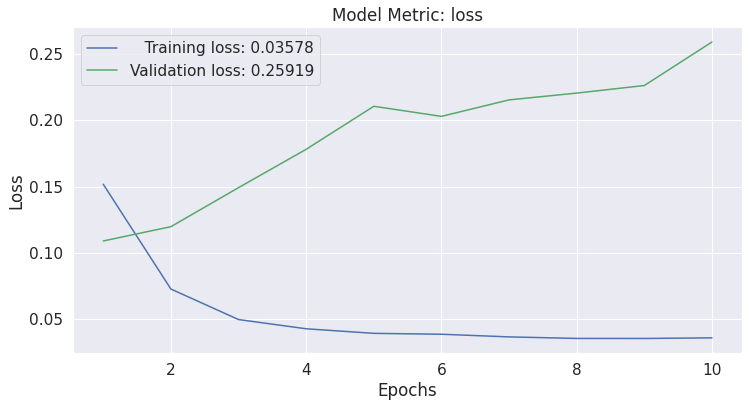

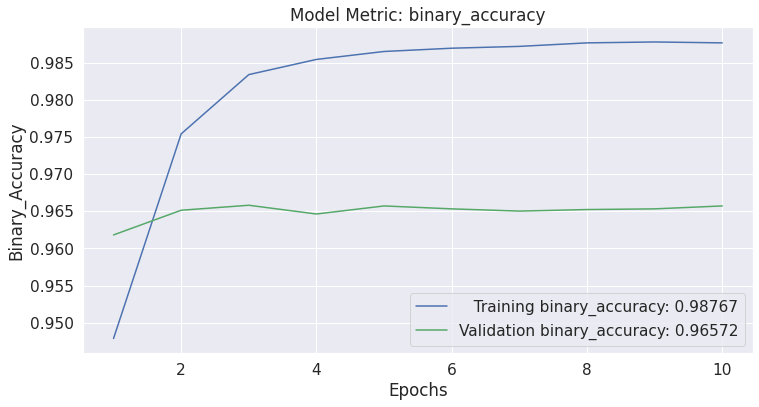

In [ ]:
plot_keras_history(history_over)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model.evaluate(
    X_val_enc_bow.todense(),    # features
    y_val_enc,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

677/677 - 1s - loss: 0.2592 - binary_accuracy: 0.9657


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.25918516516685486

Test accuracy: 96.572 %


#### Model Prediction

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict(X_test_enc_bow)
y_test_pred_probs

array([[8.2012079e-17, 1.0000000e+00],
       [1.3137019e-17, 1.0000000e+00],
       [4.8386328e-06, 9.9999499e-01],
       ...,
       [9.9999940e-01, 6.9001089e-07],
       [4.7014483e-15, 1.0000000e+00],
       [2.3046650e-07, 9.9999976e-01]], dtype=float32)

In [ ]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

# y_test_preds = model.predict_classes(X_test_enc)

y_test_preds = np.argmax(model.predict(X_test_enc_bow), axis=-1)

y_test_preds[:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [ ]:
# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

In [ ]:
y_test_pred = get_one_hot_predictions(y_test_pred_probs)
y_test_pred

# check that each line has only one 1. 
# y_test_pred.sum(axis=1)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [ ]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
y_test_pred_approval = y_enc.inverse_transform(y_test_pred).flatten()
y_test_pred_approval[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1])

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_pred_approval)
conf_mat

array([[  700,   358],
       [  288, 17766]])

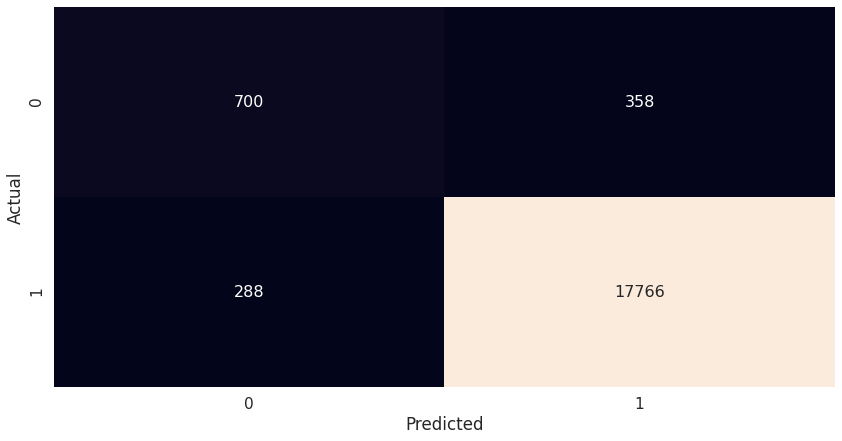

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred_approval))

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1058
           1       0.98      0.98      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.84      0.82      0.83     19112
weighted avg       0.97      0.97      0.97     19112



### Undersampling

#### Fitting (training) our Feed Forward Network Model

#### Model Evaluation

#### Model Prediction

## LSTM model

Maybe we should not remove stopwords from LSTM to capture better the context.

### With Imbalanced dataset

In [ ]:
from collections import Counter
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
          count[word] += 1
    return count

In [ ]:
text = revs_preprocessed.review
counter = counter_word(text)
len(counter)

54129

In [ ]:
counter

Counter({'γιατρος': 31458,
         'εξαιρετικη': 7194,
         'επισκεπτομαι': 488,
         '2': 649,
         'τελευταια': 199,
         'χρονια': 837,
         'προτεινω': 3349,
         'ανεπιφυλακτα': 15773,
         'ολους': 605,
         'πολυ': 59352,
         'καλος': 14319,
         'καλη': 9445,
         'ιατρος': 4326,
         'προχωραμε': 9,
         'εξειδικευμενες': 25,
         'εξετασεις': 1774,
         'ήταν': 2862,
         'δουλεια': 3171,
         'ακριβης': 919,
         'κ': 6784,
         'αναλυτικος': 2404,
         'σημαντικο': 834,
         'εμπνεει': 5547,
         'εμπιστοσυνη': 12472,
         'επισης': 1713,
         'επεξηγηματικη': 1590,
         'σχετικα': 869,
         'ολη': 665,
         'διαδικασια': 609,
         'έμεινα': 4121,
         'ευχαριστημενη': 4823,
         'καταρτισμενοςεπαγγελματιας': 1,
         'φιλικος': 6053,
         'κατανοηση': 2457,
         'αψογο': 98,
         'ιατρειο': 3842,
         'εξοπλισμος': 152,
         'έδει

In [ ]:
num_words = len(counter)

max_length = 80

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:

#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
print(revs_preprocessed.review[0])
print(train_sequences[0])

καθησυχαστικη εμπειρη αποτελεσματικη
[5, 11079, 1091, 8750, 2114, 1937, 4221]


In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(num_words, 32, input_length = max_length))
model.add(Bidirectional(LSTM(64, dropout=0.1, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.3)))
model.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 32)            1732128   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 128)           49664     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,880,737
Trainable params: 1,880,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=2, mode='auto', restore_best_weights=False)                         

#### Fitting (training) our LSTM Model

In [ ]:
history = model.fit(
 train_padded,y_train,epochs=10, validation_data=(val_padded, y_val), callbacks=early_stop
)

Epoch 1/10
2708/2708 [==============================] - 98s 36ms/step - loss: 0.1162 - accuracy: 0.9600 - val_loss: 0.0948 - val_accuracy: 0.9650
Epoch 2/10
2708/2708 [==============================] - 117s 43ms/step - loss: 0.0752 - accuracy: 0.9747 - val_loss: 0.0929 - val_accuracy: 0.9657
Epoch 3/10
2708/2708 [==============================] - 125s 46ms/step - loss: 0.0584 - accuracy: 0.9818 - val_loss: 0.1002 - val_accuracy: 0.9673
Epoch 4/10
2708/2708 [==============================] - 124s 46ms/step - loss: 0.0467 - accuracy: 0.9862 - val_loss: 0.1047 - val_accuracy: 0.9659
Epoch 5/10
2708/2708 [==============================] - 125s 46ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.1133 - val_accuracy: 0.9663
Epoch 00005: early stopping


In [ ]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

#### Model Evaluation

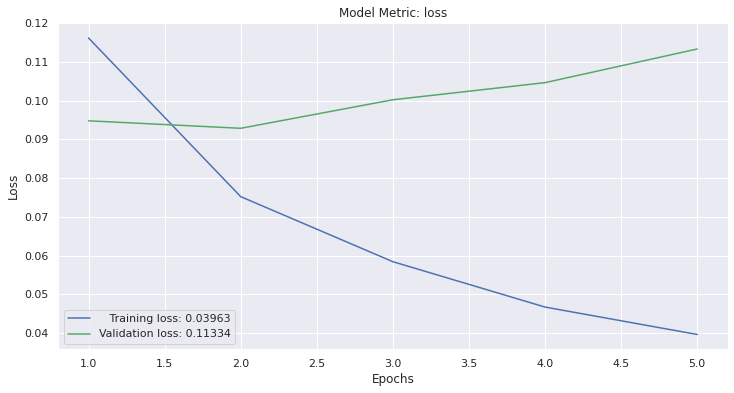

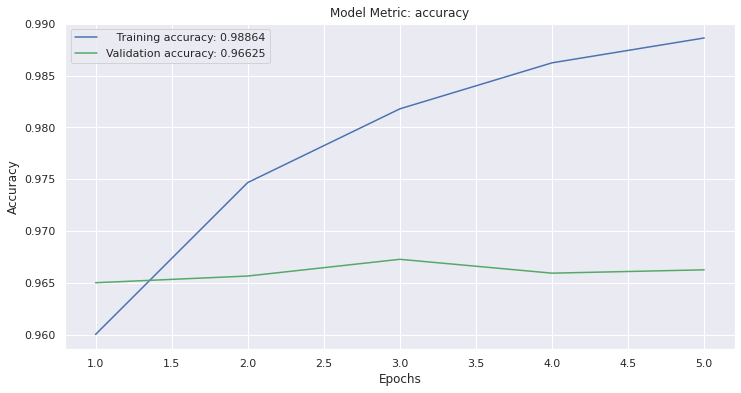

In [ ]:
sns.set()
plot_keras_history(history)

#### Model Prediction

In [ ]:
predicted = model.predict(test_padded) #change val and test
predicted = tf.greater(predicted, .5)

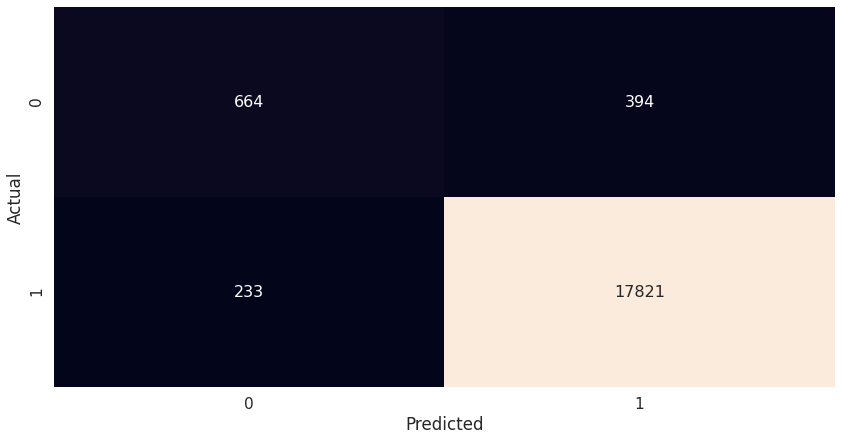

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Oversampling

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

num_words = len(counter)

max_length = 100 # mean is 800
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
not_appr_upsampled = resample(not_approved,
                          replace=True, # sample with replacement
                          n_samples=len(approved)//4, # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([approved, not_appr_upsampled])

# check new class counts
print(upsampled.approved.value_counts())
upsampled = upsampled.sample(frac=1)

1    81845
0    20461
Name: approved, dtype: int64


In [ ]:
train_sentences = upsampled.review
train_labels = upsampled.approved
val_sentences = X_val
val_labels = y_val
test_sentences = X_test
test_labels = y_test

In [ ]:
upsampled.review

63236                        πολυ ευχαριστος επικοινωνιακος
55628     εξαιρετικη γιατρος πηρε ιστορικο περιπτωση εξε...
19468     γιατρος πολυ αναλυτικος καθησυχαστικοσφυγαμε χ...
37361     πολυ εξυπηρετικη καταρτισμενη αντικειμενο εξηγ...
102946                  πολυ καλη εμεινα πολυ ικανοποιημενη
                                ...                        
15053                                            εξαιρετικη
41209     δεν ξερω ποσο κοστιζει στους γιατρους παντως κ...
74069     επεξηγηματικη φιλικη εκανε νιωσω ανετα ξαναπρο...
101012                      συστηνω ανεπιφυλακτα κ μπεκιαρη
82841            ευγενικος διακριτικος ξεκαθαρος ακομα φορα
Name: review, Length: 102306, dtype: object

In [ ]:
X_train

13985     δεν δεχεστε καρτα φτηνη δικαιολογια διαδικτυο ...
25928                                          ευγενεστατος
41869                                         καταπληκτικος
53268                                     εξερετικος ιατρος
15336                              ολα αψογα ευχαριστω πολυ
                                ...                        
30200                                      απλα εξαιρετικος
90133     καταπληκτικη γιατροςμε εξετασε λεπτομερεια οδη...
11206     καταπληκτικος εξηγουσε παντα πολυ απλα λογιαμε...
99523     αξιολογος γιατρος ηθος εμπειρια ραντεβου ωρα σ...
107858    εξαιρετικος γιατρος εμπειρια γνωση πραγματικα ...
Name: review, Length: 86640, dtype: object

In [ ]:
val_labels.value_counts()

1    20461
0     1199
Name: approved, dtype: int64

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
#word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sentences = tokenizer.texts_to_sequences(X_val)
test_sentences = tokenizer.texts_to_sequences(X_test)

In [ ]:
#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sentences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

model_over = Sequential()

model_over.add(Embedding(num_words, 32, input_length = max_length))
#model_over.add(Bidirectional(LSTM(64, dropout=0.1, return_sequences=True)))
#model_over.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
model_over.add(Bidirectional(LSTM(64, dropout=0.3)))
model_over.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
model_over.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

model_over.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           1732128   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,781,921
Trainable params: 1,781,921
Non-trainable params: 0
_________________________________________________________________


#### Fitting (training) our LSTM Model

In [ ]:
history_over = model_over.fit(
 train_padded,train_labels,epochs=10, validation_data=(val_padded, y_val), callbacks=early_stop
)

Epoch 1/10
3198/3198 [==============================] - 84s 26ms/step - loss: 0.2139 - accuracy: 0.9211 - val_loss: 0.1109 - val_accuracy: 0.9620
Epoch 2/10
3198/3198 [==============================] - 82s 26ms/step - loss: 0.1188 - accuracy: 0.9623 - val_loss: 0.0988 - val_accuracy: 0.9669
Epoch 3/10
3198/3198 [==============================] - 83s 26ms/step - loss: 0.0874 - accuracy: 0.9728 - val_loss: 0.1098 - val_accuracy: 0.9630
Epoch 4/10
3198/3198 [==============================] - 89s 28ms/step - loss: 0.0720 - accuracy: 0.9784 - val_loss: 0.1148 - val_accuracy: 0.9639
Epoch 5/10
3198/3198 [==============================] - 86s 27ms/step - loss: 0.0619 - accuracy: 0.9820 - val_loss: 0.1285 - val_accuracy: 0.9629
Epoch 00005: early stopping


#### Model Evaluation

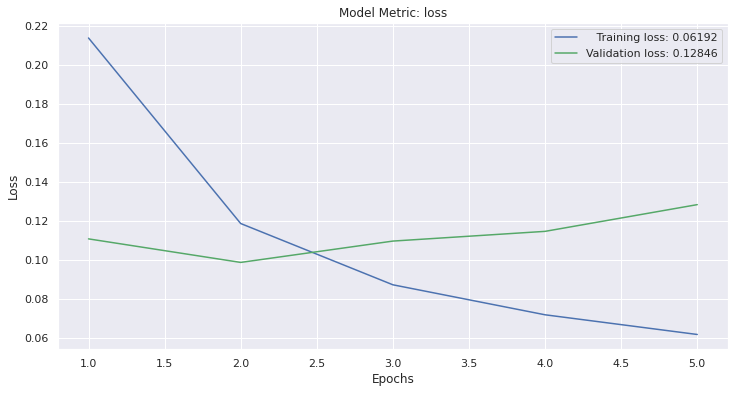

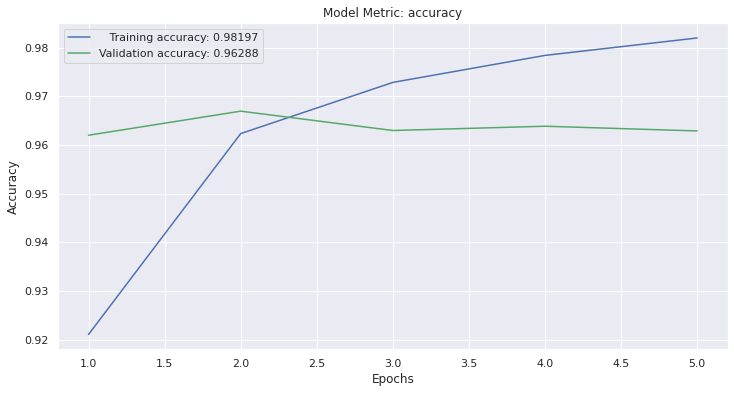

In [ ]:
sns.set()
plot_keras_history(history_over)

#### Model Prediction

In [ ]:
predicted_over = model_over.predict(test_padded) #change val and test
predicted_over = tf.greater(predicted_over, .5)

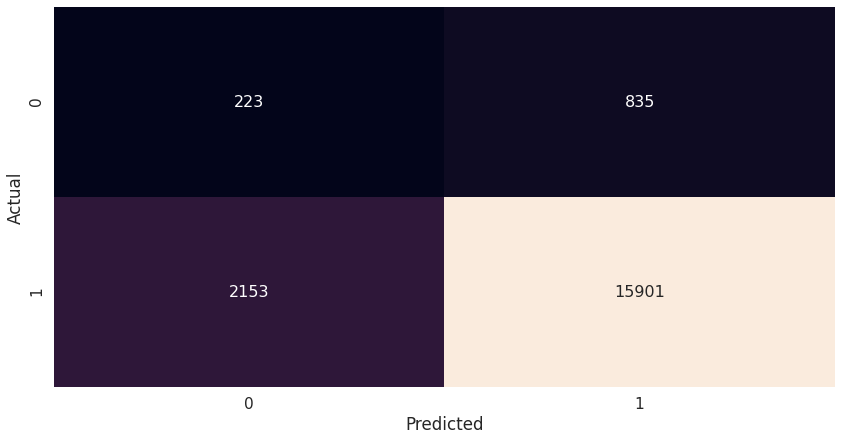

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted_over)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Undersampling

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

num_words = len(counter)

max_length = 60
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
appr_downsampled = resample(approved,
                          replace=True, # sample with replacement
                          n_samples=25000, # match number in majority class
                          random_state=27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_approved, appr_downsampled])

# check new class counts
print(downsampled.approved.value_counts())
downsampled = downsampled.sample(frac=1) #shuffle

1    25000
0     4795
Name: approved, dtype: int64


In [ ]:
train_sentences = downsampled.review
train_labels = downsampled.approved
val_sentences = X_val
val_labels = y_val
test_sentences = X_test
test_labels = y_test

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
#word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sentences = tokenizer.texts_to_sequences(X_val)
test_sentences = tokenizer.texts_to_sequences(X_test)

In [ ]:
#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sentences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

model_under = Sequential()

model_under.add(Embedding(num_words, 32, input_length = max_length))
model_under.add(Bidirectional(LSTM(64 ,dropout=0.1)))
model_under.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
model_under.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

model_under.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 32)            1732128   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 1,781,921
Trainable params: 1,781,921
Non-trainable params: 0
_________________________________________________________________


#### Fitting (training) our LSTM Model

In [ ]:
history_under = model_under.fit(
 train_padded,train_labels,epochs=10, validation_data=(val_padded, val_labels, early_stop)
)

Epoch 1/10
932/932 [==============================] - 25s 27ms/step - loss: 0.2914 - accuracy: 0.8847 - val_loss: 0.1319 - val_accuracy: 0.9556
Epoch 2/10
932/932 [==============================] - 24s 26ms/step - loss: 0.1636 - accuracy: 0.9457 - val_loss: 0.1154 - val_accuracy: 0.9600
Epoch 3/10
932/932 [==============================] - 24s 26ms/step - loss: 0.1304 - accuracy: 0.9587 - val_loss: 0.1128 - val_accuracy: 0.9604
Epoch 4/10
932/932 [==============================] - 24s 26ms/step - loss: 0.1058 - accuracy: 0.9681 - val_loss: 0.1190 - val_accuracy: 0.9601
Epoch 5/10
932/932 [==============================] - 24s 26ms/step - loss: 0.0883 - accuracy: 0.9743 - val_loss: 0.1206 - val_accuracy: 0.9579
Epoch 6/10
932/932 [==============================] - 24s 25ms/step - loss: 0.0762 - accuracy: 0.9790 - val_loss: 0.1334 - val_accuracy: 0.9571
Epoch 7/10
932/932 [==============================] - 24s 25ms/step - loss: 0.0664 - accuracy: 0.9818 - val_loss: 0.1438 - val_accuracy:

#### Model Evaluation

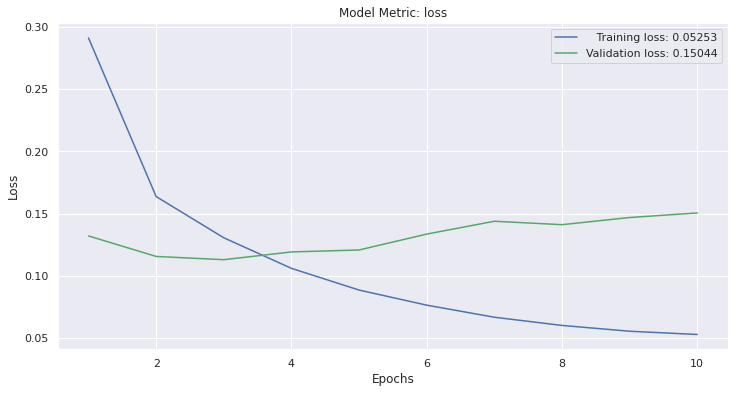

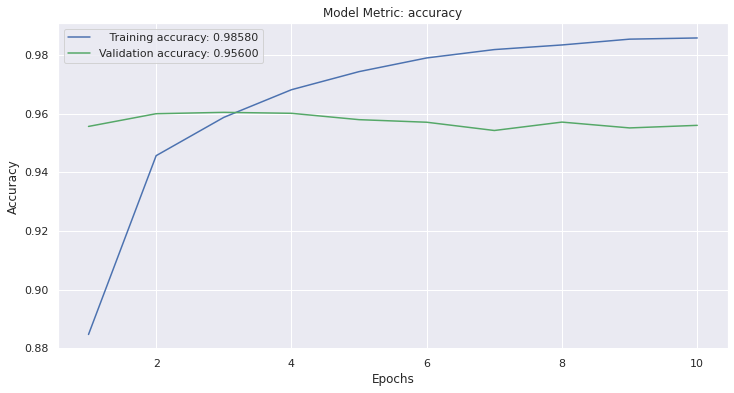

In [ ]:
sns.set()
plot_keras_history(history_under)

#### Model Prediction

In [ ]:
predicted_under = model_over.predict(test_padded) #change val and test
predicted_under = tf.greater(predicted_under, .5)

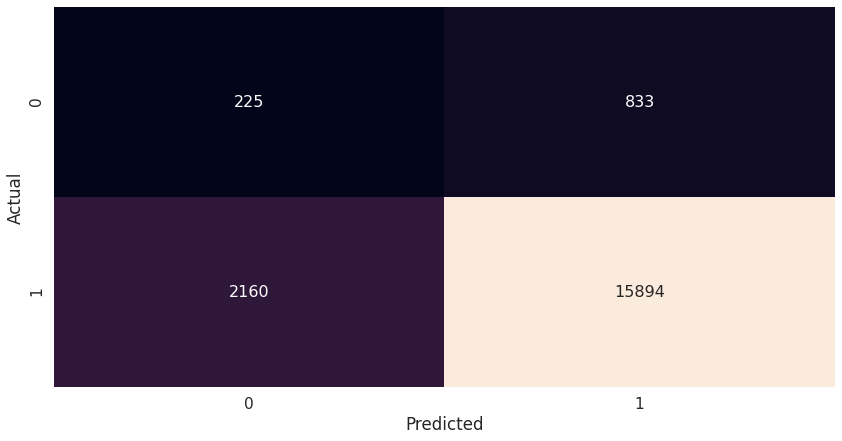

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted_under)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})